(example_1)=
Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from metadpy import load_dataset
from metadpy.mle import metad
from metadpy.plotting import plot_confidence, plot_roc

sns.set_context("talk")

In this notebook, we are going to estimate meta-*d'* using Maximum Likelihood Estimation ([MLE](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)) {cite:p}`fleming:2014,maniscalo:2014,maniscalo:2012` using the function implemented in [metadpy](https://github.com/LegrandNico/metadpy). This function is directly adapted from the transcription of the Matlab `fit_meta_d_MLE.m` by Alan Lee that can be retrieved [here](http://www.columbia.edu/~bsm2105/type2sdt/).

We are going to see, however, that [metadpy](https://github.com/LegrandNico/metadpy) greatly simplifies the preprocessing of raw data, letting the user fit the model for many participants/groups/conditions from the results data frame in a single command call. Another advantage here is that the python code supporting the model fitting is optimized using [Numba](http://numba.pydata.org/), which greatly improves its performance.

# Fitting at the subject level

## From response-signal arrays

In [2]:
# Create responses data
nR_S1 = np.array([52, 32, 35, 37, 26, 12, 4, 2])
nR_S2 = np.array([2, 5, 15, 22, 33, 38, 40, 45])

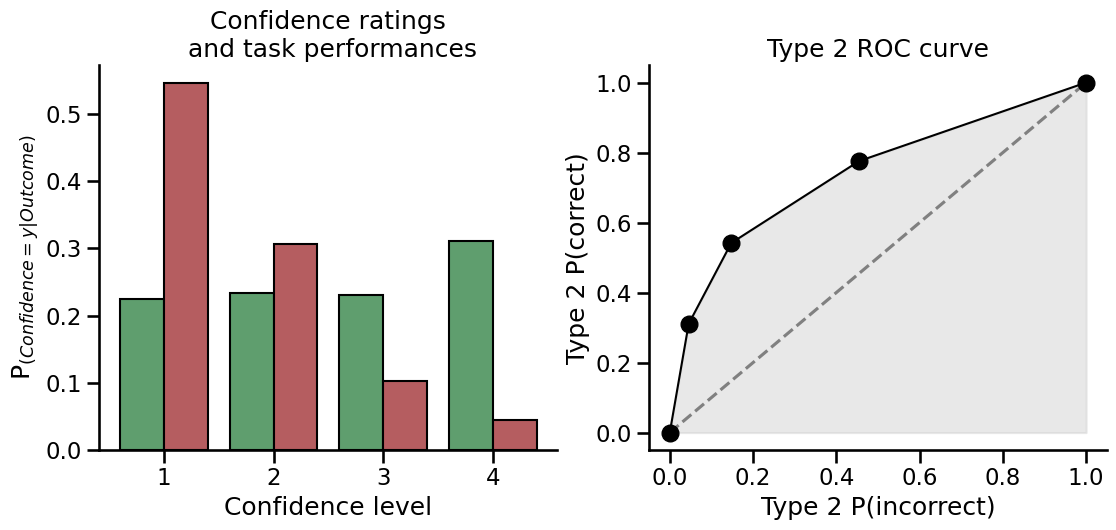

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
plot_confidence(nR_S1, nR_S2, ax=axs[0])
plot_roc(nR_S1, nR_S2, ax=axs[1])
sns.despine()

The model is fitted using the `metadpy.mle.metad()` function. This function accepts response-signal arrays as input if the data comes from a single subject.

In [4]:
output = metad(nR_S1=nR_S1, nR_S2=nR_S2)

In [5]:
output

,dprime,meta_d,m_ratio,m_diff
0,1.534994,1.63376,1.064343,0.098766


The function will return a data frame containng the `dprime`, `metad`, `m_ratio` and `m_diff` scores for this participant.

## From a data frame
To simplify the preprocessing steps, the model can also be fitted directly from the raw result data frame. The data frame should contain the following columns:

* `Stimuli`: Which of the two stimuli was presented [0 or 1].
* `Response` or `Accuracy`: The response provided by the participant or the accuracy [0 or 1].
* `Confidence`: The confidence level [can be continuous or discrete].

In addition, it can also integrate:
* `Subject`: The subject ID.
* `within` or `between`: The condition or the group ID (if many groups or conditions were used).

Note that the MLE method will always fit the participant separately (i.e. in a non-hierarchical way), which means that the results will be the same by fitting each participant and condition separately (e.g. in a for loop).

In [6]:
df = load_dataset("rm")
df.head()

,Stimuli,Responses,Accuracy,Confidence,nTrial,Subject,Condition
0,0,0,1,4,0,0,0
1,1,1,1,4,1,0,0
2,0,1,0,4,2,0,0
3,1,0,0,1,3,0,0
4,1,1,1,2,4,0,0


In [7]:
subject_fit = metad(
    data=df[df.Subject == 0].copy(),
    nRatings=4,
    stimuli="Stimuli",
    accuracy="Accuracy",
    confidence="Confidence",
    padding=True,
)

In [8]:
subject_fit.head()

,dprime,meta_d,m_ratio,m_diff
0,0.999247,0.781983,0.782573,-0.217264


# Fitting at the group level

## Using a dataframe

In [9]:
group_fit = metad(
    data=df,
    nRatings=4,
    stimuli="Stimuli",
    accuracy="Accuracy",
    confidence="Confidence",
    subject="Subject",
    padding=True,
    within="Condition",
)

In [10]:
group_fit.head()

,dprime,meta_d,m_ratio,m_diff,Subject,Condition
0,0.959244,0.739642,0.771068,-0.219601,0,0
0,1.006310,0.790893,0.785934,-0.215417,0,1
0,1.117543,1.084441,0.970379,-0.033103,1,0
0,0.967871,0.869539,0.898404,-0.098332,1,1
0,0.792528,0.670130,0.845560,-0.122398,2,0


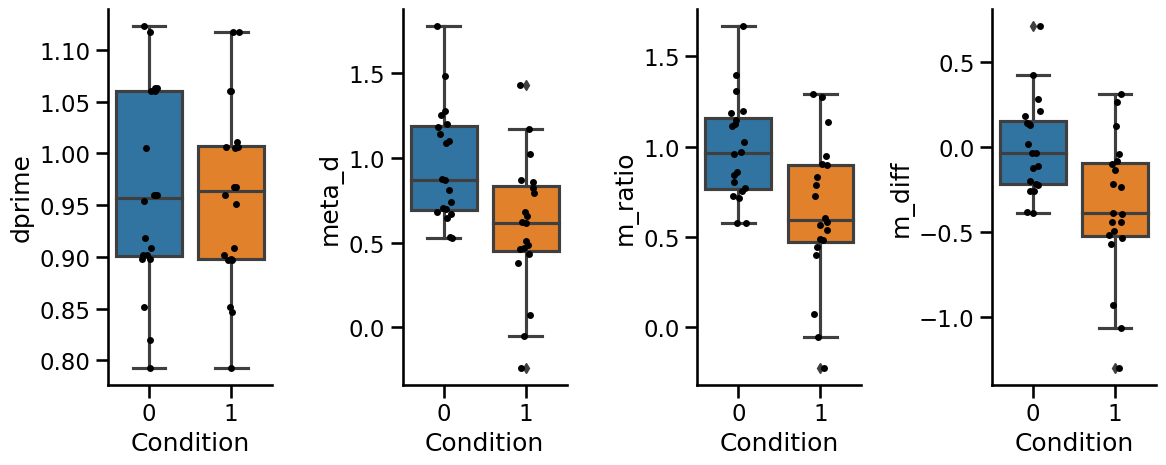

In [11]:
_, axs = plt.subplots(1, 4, figsize=(12, 5), sharex=True)

for i, metric in enumerate(["dprime", "meta_d", "m_ratio", "m_diff"]):

    sns.boxplot(data=group_fit, x="Condition", y=metric, ax=axs[i])
    sns.stripplot(data=group_fit, x="Condition", y=metric, color="k", ax=axs[i])

plt.tight_layout()
sns.despine()

# Watermark

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -p metadpy,jax,numpyro,pymc

Last updated: Wed Nov 02 2022

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.4.0

metadpy: 0.0.1
jax    : 0.3.5
numpyro: not installed
pymc   : 4.3.0

matplotlib: 3.4.3
seaborn   : 0.12.1
numpy     : 1.19.0

Watermark: 2.3.1

